# 1. Setup

In [194]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [235]:
import nltk 
from nltk.corpus import stopwords
from nltk import word_tokenize
import numpy as np

import matplotlib        as mpl
import matplotlib.pyplot as plt

import os
import tempfile
import pandas as pd
import re

import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow import keras

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

print('Setup completed')

Setup completed


# 2. Data processing and Exploration

In [196]:
bugs = pd.read_csv('datasets/gcc_bug_report_data.csv', encoding='utf8', sep=',', parse_dates=True,low_memory=False)

In [197]:
bugs['long_lived?']  = bugs['bug_fix_time'].apply(lambda t: 1 if t > 365 else 0)


In [198]:
bugs=bugs[['long_description','long_lived?']]
bugs.head()

,long_description,long_lived?
0,The Openstreetmap applet expects java.awt.Font...,0
1,As reported by Joost VandeVondele this does no...,0
2,$ gcc/xgcc -Bgcc/ -O2 -fpic -S memusage.i \nme...,1
3,The RM95 B.3.1 contains: The type chars_ptr is...,0
4,Created attachment 29408\nPreprocessed file co...,0


In [199]:
def print_bug(df, index):
    example=df.loc[df.index == index][['long_description', 'long_lived?']].values[0]
    if(len (example) > 0):
        print(example[0])
        print('long_lived?', example[1])

In [200]:
print_bug(bugs, 100)

Compile testcase in attachment 23385 (bug 47786) with `gcc -v -flto -o /dev/null main.i foo.i':

/usr/local/libexec/gcc/i686-pc-linux-gnu/4.6.0/cc1 -fpreprocessed main.i foo.i -quiet -dumpbase main.i -mtune=generic -march=pentiumpro -auxbase main -version -flto -o /tmp/cc3eBz9m.s

I don't think it is an intended behavior.
long_lived? 0


## Examine Class Labels imbalanced

In [201]:
neg, pos = np.bincount(bugs['long_lived?'])
total = neg + pos
print('Examples:\n Total: {}\n Positive: {}\n ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
 Total: 10000
 Positive: 2915
 (29.15% of total)



# 3. Cleaning, tokenizing and splitting data

## Cleaning

In [202]:
cleaned_bugs = bugs.copy()
cleaned_bugs = cleaned_bugs.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    if text != text:
        return ' '
    
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
cleaned_bugs['long_description'] = cleaned_bugs['long_description'].apply(clean_text)
cleaned_bugs['long_description'] = cleaned_bugs['long_description'].str.replace('\d+', '')

In [203]:
print_bug(cleaned_bugs, 100)

compile testcase attachment  bug  gcc v flto dev null maini fooi usr local libeec gcc ipclinugnu  cc fpreprocessed maini fooi quiet dumpbase maini mtunegeneric marchpentiumpro aubase main version flto tmp ccebzmsi dont think intended behavior
long_lived? 0


## Tokenizing

In [204]:
MAX_NB_WORDS        = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM       = 100

# Vectorize a text corpus, by turning each text into sequence of integers
# (each integer being index of a token dictionary) or into a vector where
# the coefficient for each token could be binary, based on word count, base 
# on tf-idf
#
# Arguments:
#    
#    num_words: the maximum number of words to keep, based on word frequency. 
#    filters  : a string where each element is a character that will be filtered from the texts.
#    lower    : boolean. Whether to convert to texts to lowercase.
tokenizer = Tokenizer(num_words=MAX_NB_WORDS
                      , filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
                      , lower=True)


# Updates internal vocabulary based on a list of texts. 
# This method creates the vocabulary index based on word frequency.
tokenizer.fit_on_texts(cleaned_bugs['long_description'].values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))




Found 148064 unique tokens.


In [205]:
# Transforms each text in texts to a sequence of integers.
X = tokenizer.texts_to_sequences(cleaned_bugs['long_description'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10000, 250)


In [206]:
Y = pd.get_dummies(cleaned_bugs['long_lived?']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (10000, 2)


## Splitting

In [207]:
# Split arrays or matrices into random train and test subsets
# 
# Arguments:
# 
#   *arrays   - allowed input are lists, numpy arrays, scipy-sparce matrices or pandas dataframes.
#   test_size - if float, should be between 0.0 and 1.0 and represent the proportion of dataset to include
#               in test split. If int, represents the absolute number of test samples. If None, the value 
#               is set to the complement of the train size. If train_size is also None, it will set to 0.25


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print('Training shape  : ', X_train.shape, Y_train.shape)
print('Validation shape: ', X_val.shape, Y_val.shape)
print('Test shape      : ', X_test.shape, Y_test.shape)

Training shape  :  (6400, 250) (6400, 2)
Validation shape:  (1600, 250) (1600, 2)
Test shape      :  (2000, 250) (2000, 2)


In [208]:
# TODO: look at data distribution

## Defining Models and Metrics

In [209]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]
def make_model(metrics=METRICS, output_bias=None, input_dim=MAX_NB_WORDS
               , output_dim=EMBEDDING_DIM, input_length=MAX_NB_WORDS):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    model = keras.Sequential([
        keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length),
        keras.layers.SpatialDropout1D(0.2),
        keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2),
        keras.layers.Dense(2,  activation='sigmoid')
    ])
    
    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
    
    return model

## Baseline Model

### Build Model

In [217]:
EPOCHS     = 20
BATCH_SIZE = 1024

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [218]:
model = make_model(input_length=X.shape[1])
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_31 (Spatia (None, 250, 100)          0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________


Test run model:

In [219]:
model.predict(X_train[:10])

array([[0.49522135, 0.49618542],
       [0.49897107, 0.50563633],
       [0.50059915, 0.49923265],
       [0.5007877 , 0.498933  ],
       [0.49972466, 0.49490243],
       [0.49841478, 0.49803153],
       [0.50862145, 0.4983345 ],
       [0.50145376, 0.49847937],
       [0.5013664 , 0.4987493 ],
       [0.5040208 , 0.4980269 ]], dtype=float32)

### default bias initialization

In [220]:
model   = make_model(input_length=X.shape[1])
results = model.evaluate(X_train, Y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {0:4f}".format(results[0]))

Loss: 0.693471


### custom bias initialization

In [221]:
initial_bias = np.log([pos/neg])
initial_bias

array([-0.88811005])

In [222]:
model = make_model(output_bias=initial_bias, input_length=X.shape[1])
results = model.evaluate(X_train, Y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {0:4f}".format(results[0]))

Loss: 0.693428


### checkpoint the initial weights

In [223]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

### confirm that the bias fix help

In [152]:
model = make_model(input_length=X.shape[1])
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0, 0.0])
zero_bias_history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=5,
    validation_data=(X_val, Y_val), 
    verbose=1)

Train on 6400 samples, validate on 1600 samples
Epoch 1/5
6400/6400 [==============================] - 53s 8ms/sample - loss: 0.6819 - tp: 4244.0000 - fp: 2129.0000 - tn: 4271.0000 - fn: 2156.0000 - accuracy: 0.6652 - precision: 0.6659 - recall: 0.6631 - auc: 0.7041 - val_loss: 0.6442 - val_tp: 1154.0000 - val_fp: 446.0000 - val_tn: 1154.0000 - val_fn: 446.0000 - val_accuracy: 0.7212 - val_precision: 0.7212 - val_recall: 0.7212 - val_auc: 0.7545
Epoch 2/5
6400/6400 [==============================] - 44s 7ms/sample - loss: 0.6194 - tp: 4524.0000 - fp: 1876.0000 - tn: 4524.0000 - fn: 1876.0000 - accuracy: 0.7069 - precision: 0.7069 - recall: 0.7069 - auc: 0.7187 - val_loss: 0.5876 - val_tp: 1154.0000 - val_fp: 446.0000 - val_tn: 1154.0000 - val_fn: 446.0000 - val_accuracy: 0.7212 - val_precision: 0.7212 - val_recall: 0.7212 - val_auc: 0.7804
Epoch 3/5
6400/6400 [==============================] - 44s 7ms/sample - loss: 0.5918 - tp: 4524.0000 - fp: 1876.0000 - tn: 4524.0000 - fn: 1876.0000

In [154]:
model = make_model(input_length=X.shape[1])
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=5,
    validation_data=(X_val, Y_val), 
    verbose=1)

Train on 6400 samples, validate on 1600 samples
Epoch 1/5
6400/6400 [==============================] - 51s 8ms/sample - loss: 0.6821 - tp: 4226.0000 - fp: 2081.0000 - tn: 4319.0000 - fn: 2174.0000 - accuracy: 0.6676 - precision: 0.6700 - recall: 0.6603 - auc: 0.7049 - val_loss: 0.6439 - val_tp: 1154.0000 - val_fp: 446.0000 - val_tn: 1154.0000 - val_fn: 446.0000 - val_accuracy: 0.7212 - val_precision: 0.7212 - val_recall: 0.7212 - val_auc: 0.7544
Epoch 2/5
6400/6400 [==============================] - 40s 6ms/sample - loss: 0.6144 - tp: 4524.0000 - fp: 1876.0000 - tn: 4524.0000 - fn: 1876.0000 - accuracy: 0.7069 - precision: 0.7069 - recall: 0.7069 - auc: 0.7220 - val_loss: 0.5829 - val_tp: 1154.0000 - val_fp: 446.0000 - val_tn: 1154.0000 - val_fn: 446.0000 - val_accuracy: 0.7212 - val_precision: 0.7212 - val_recall: 0.7212 - val_auc: 0.7823
Epoch 3/5
6400/6400 [==============================] - 40s 6ms/sample - loss: 0.5833 - tp: 4524.0000 - fp: 1876.0000 - tn: 4524.0000 - fn: 1876.0000

In [168]:
def plot_loss(history, label, n):
    plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch, history.history['val_loss'], color=colors[n], label='Val '+label, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    

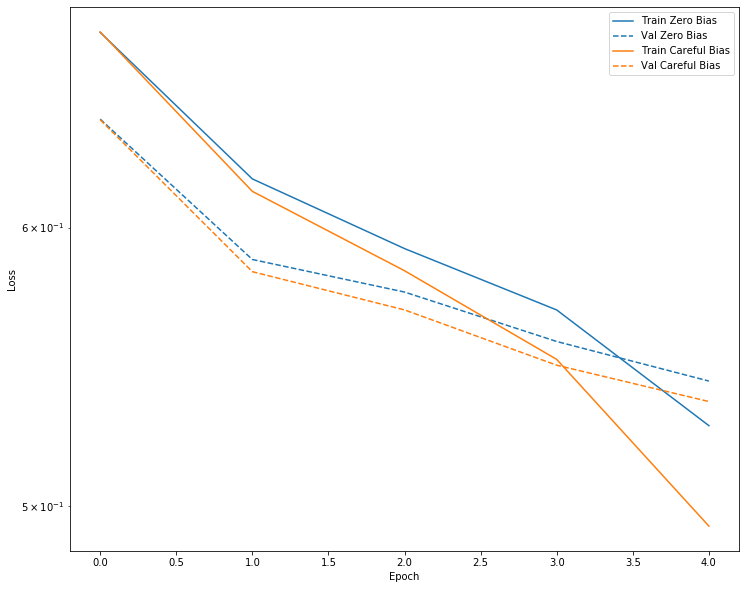

In [170]:
plot_loss(zero_bias_history, 'Zero Bias', 0)
plot_loss(careful_bias_history, 'Careful Bias', 1)

### Train Model

In [224]:
model = make_model(input_length=X.shape[1])
model.load_weights(initial_weights)
baseline_history    = model.fit(X_train
                       , Y_train
                       , epochs=EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_val, Y_val)
                       , callbacks=[early_stopping])

Train on 6400 samples, validate on 1600 samples
Epoch 1/20
6400/6400 [==============================] - 40s 6ms/sample - loss: 0.6849 - tp: 4324.0000 - fp: 2363.0000 - tn: 4037.0000 - fn: 2076.0000 - accuracy: 0.6532 - precision: 0.6466 - recall: 0.6756 - auc: 0.6934 - val_loss: 0.6590 - val_tp: 1154.0000 - val_fp: 446.0000 - val_tn: 1154.0000 - val_fn: 446.0000 - val_accuracy: 0.7212 - val_precision: 0.7212 - val_recall: 0.7212 - val_auc: 0.7642
Epoch 2/20
6400/6400 [==============================] - 37s 6ms/sample - loss: 0.6279 - tp: 4524.0000 - fp: 1876.0000 - tn: 4524.0000 - fn: 1876.0000 - accuracy: 0.7069 - precision: 0.7069 - recall: 0.7069 - auc: 0.7190 - val_loss: 0.5825 - val_tp: 1154.0000 - val_fp: 446.0000 - val_tn: 1154.0000 - val_fn: 446.0000 - val_accuracy: 0.7212 - val_precision: 0.7212 - val_recall: 0.7212 - val_auc: 0.7803
Epoch 3/20
6400/6400 [==============================] - 35s 5ms/sample - loss: 0.5865 - tp: 4524.0000 - fp: 1876.0000 - tn: 4524.0000 - fn: 1876.0

### Check training history

In [225]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
          plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
          plt.ylim([0.8,1])
        else:
          plt.ylim([0,1])

    plt.legend()

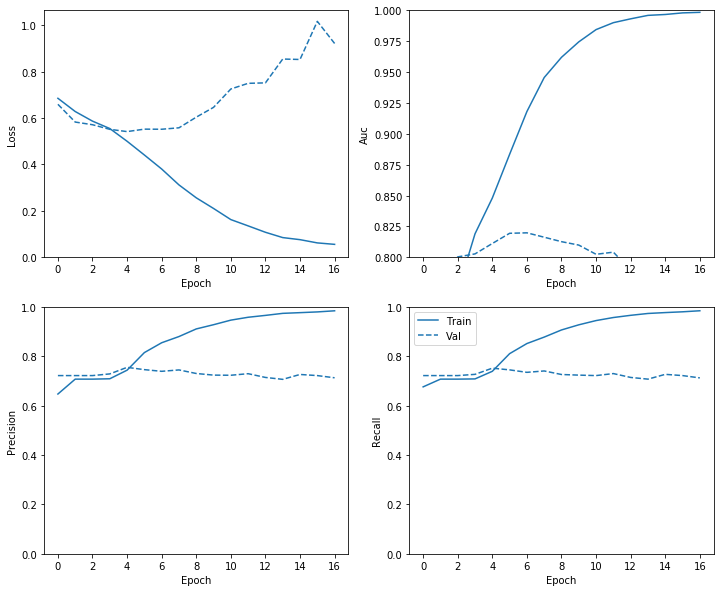

In [226]:
plot_metrics(baseline_history)

### Evaluate metrics

In [227]:
train_predictions_baseline = model.predict_classes(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline  = model.predict_classes(X_test, batch_size=BATCH_SIZE)

In [228]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  ba = ((cm[1][1]/(cm[1][1]+cm[1][0])) + (cm[0][0]/(cm[0][0]+cm[0][1]))) / 2
  print('Short-lived (True Negatives): ', cm[0][0])
  print('Short-lived Missed (False Positives): ', cm[0][1])
  print('Long-Lived (True Positives): ', cm[1][1])
  print('Long-Lived Missed (False Negatives): ', cm[1][0])
  print('Total Of Long-Liveds: ', np.sum(cm[1]))
  print('Balanced Accuracy: ', ba)

In [231]:
baseline_results = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

loss :  0.6048513793945313
tp :  1467.0
fp :  518.0
tn :  1482.0
fn :  533.0
accuracy :  0.73725
precision :  0.7390428
recall :  0.7335
auc :  0.7940033



Short-lived (True Negatives):  1222
Short-lived Missed (False Positives):  185
Long-Lived (True Positives):  254
Long-Lived Missed (False Negatives):  339
Total Of Long-Liveds:  593
Balanced Accuracy:  0.648422546386353


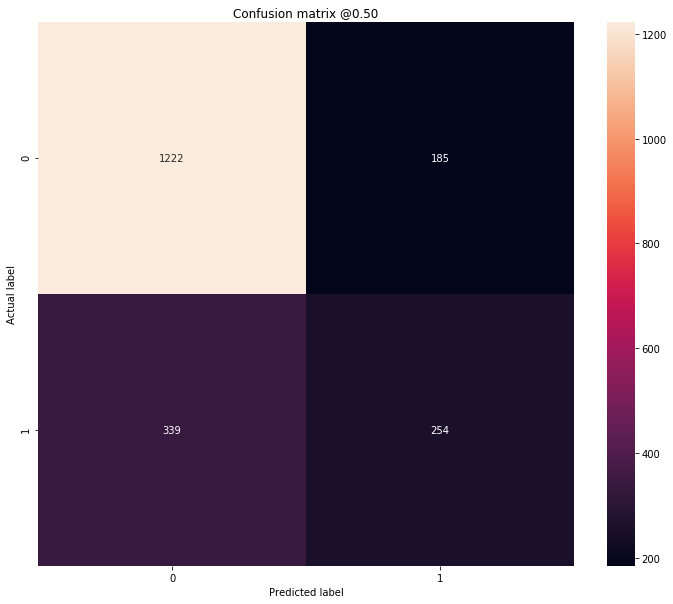

In [232]:
plot_cm(Y_test.argmax(axis=1), test_predictions_baseline)

In [233]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

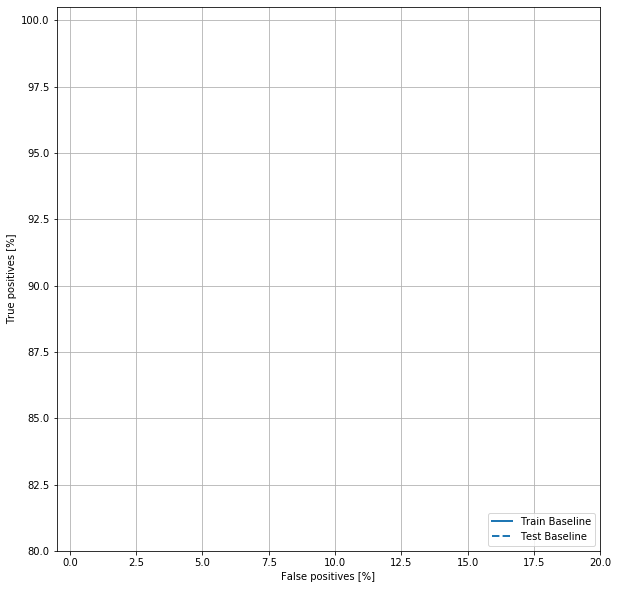

In [238]:
plot_roc("Train Baseline", Y_train.argmax(axis=1), train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_test.argmax(axis=1), test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')